In [1]:
import numpy as np
from magic import movie, symmetrize
import os

import time
import progressbar as pbar

from netCDF4 import Dataset, date2num, num2date
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib import rcParams

import cartopy
from parcels import FieldSet, ParticleSet, Variable, \
                    JITParticle, AdvectionRK4, plotTrajectoriesFile, ErrorCode

%matplotlib inline


In [3]:
# Get magic data

#data_path = '/media/rakesh/Seagate Expansion Drive1/Data2/Polar_vortex_runs/Eta0.8/Ek1e-4/eta_0.8_Pr1e-1_Ra5e6'
#U_filename = "Vp_R=C4_mov.tag_a" # Zonal
#V_filename = "Vt_R=C3_mov.tag_a" # Meridional

# Hexagon run file
#data_path = '/media/rakesh/Seagate Expansion Drive/Data2/Polar_vortex_runs/Eta0.9/Nrho5/eta_0.9_Pr1e-1_Ra2.3e8_hyd_Nrho5'
#U_filename = "Vp_R=C5_mov.tag_zv"
#V_filename = "Vt_R=C1_mov.tag_zv"

# Thin shell Eta=0.97 case
data_path = '/media/rakesh/Seagate Expansion Drive1/Data2/Polar_vortex_runs/Eta0.97/Bou/eta_0.97_Pr1e-1_Ra3e7_Bou_minc4'
U_filename = "Vp_R=C4_mov.tag_e"
V_filename = "Vt_R=C3_mov.tag_e"

# Dynamo anticylones case
#data_path = '/media/rakesh/Seagate Expansion Drive1/Data/Pleiades/Ek1e-6_tanh_cond_Nrho5/Ek1e-6_Pr0.1_Pm1.5_Nrho5_Ra4e9_Eta0.1_tanh_rcut0.85'
#U_filename = "Vp_R=C5_mov.tag_zn"
#V_filename = "Vt_R=C7_mov.tag_zn"

os.chdir(data_path)
U_frames =  movie.Movie(file=U_filename, iplot=False)
V_frames =  movie.Movie(file=V_filename, iplot=False)

nframes = U_frames.nvar
print('Data has {} frames, {} points in lat, {} points in lon, and minc {}.'.format(U_frames.nvar, 
                                                                           U_frames.data.shape[3], 
                                                                           U_frames.data.shape[2],
                                                                           U_frames.minc))

Data has 362 frames, 2112 points in lat, 1056 points in lon, and minc 4.


In [36]:

def makeCDF(ncout, hrs, lats, lons, udata, vdata, remove_zon_flow=False):
    
    
    # define axis size
    ncout.createDimension('time', 1)  
    ncout.createDimension('lat', len(lats))
    ncout.createDimension('lon', len(lons))

    
    # create longitude axis
    longitude = ncout.createVariable('Longitude', 'float32', 'lon')
    #longitude.standard_name = 'longitude'
    #longitude.long_name = 'longitude'
    longitude.units = 'degrees east'
    #lon.axis = 'X'
    
    # create latitude axis
    latitude = ncout.createVariable('Latitude', 'float32', 'lat')
    #latitude.standard_name = 'latitude'
    #latitude.long_name = 'latitude'
    latitude.units = 'degrees north'
    #lat.axis = 'Y'
    
    # create time axis
    time = ncout.createVariable('time', 'float32', ('time',))
    #time.long_name = 'time'
    time.units = 'hours since 1987-03-30'
    #time.calendar = 'standard'
    #time.axis = 'T'

    
    # create variable array
    uout = ncout.createVariable('U', 'float32', ('time', 'lat', 'lon'))
    #uout.long_name = 'zon'
    uout.units = 'Rey'

    # create variable array
    vout = ncout.createVariable('V', 'float32', ('time', 'lat', 'lon'))
    #vout.long_name = 'mer'
    vout.units = 'Rey'
    
    if remove_zon_flow==True:
        udata = udata - np.mean(udata, axis=0)
    
    
    # Northern hemi data is in the 2nd half of the latitude array -> "-len(lats):"
    uout[:,:,:] = np.reshape(udata.T[-len(lats): ,0:len(lons)], (1,len(lats),len(lons)))
    vout[:,:,:] = np.reshape(vdata.T[-len(lats): ,0:len(lons)], (1,len(lats),len(lons)))
    
    
    latitude[:] = lats
    longitude[:] = lons
    #print(uout[:,:,:].shape, latitude[:].shape, longitude[:].shape)
    hrs = timedelta(hours=hrs) # time passed in DD:HH:MM:SS
    date = datetime(1987,3,30) + hrs # add time passed to starting date
    
    time[:] = date2num(date, time.units)
    #print('File written for:', time[:], time.units)

In [40]:
nlats=int(U_frames.data.shape[3]/2) #choose only northern hemisphere
nlons=int(U_frames.data.shape[2]*U_frames.minc)

lats =  np.linspace(0, 90, nlats, dtype=np.float32) # equ to north pole
lons =  np.linspace(-180, 180, nlons, dtype=np.float32) # Greenwich meridian eastward

# To scale the flow velocity; Oceanparcels assumes m/s flow
# Can be used to control how much distance 
# particles travel from frame-to-frame
#
scale_flow = 0.01 # for Eta0.97 run
remove_zon_flow=True
#scale_flow = 0.005 # Hexagon run
#scale_flow = 0.001 # Dynamo anticyclone run
nfiles = 300

os.chdir('/home/rakesh/Desktop/Particle_tracing/magic_CDF_files')


#bar = IncrementalBar('Files written', max = nfiles)

for i in pbar.progressbar(range(nfiles)): # i represents number of hours passed
    ncout = Dataset('UV_frame_{:04d}.nc'.format(i), 'w', format='NETCDF4')
    makeCDF(ncout, i, lats, lons, 
            symmetrize(U_frames.data[0,i,:,:], U_frames.minc)*scale_flow, 
            symmetrize(V_frames.data[0,i,:,:], U_frames.minc)*scale_flow,
            remove_zon_flow=remove_zon_flow)
    ncout.close();del ncout # close file
    #print('Frames done', i)
    #time.sleep(0.01)



100% (300 of 300) |######################| Elapsed Time: 0:00:29 Time:  0:00:29


In [41]:
# go to the dir with .nc files
os.chdir('/home/rakesh/Desktop/Particle_tracing')

filenames = {'U': "magic_CDF_files/UV_frame_*.nc",
             'V': "magic_CDF_files/UV_frame_*.nc"}

variables = {'U': 'U',
             'V': 'V'}

dimensions = {'lat': 'Latitude',
              'lon': 'Longitude', 
              'time': 'time'}

fieldset = FieldSet.from_netcdf(filenames, variables, dimensions,
                               allow_time_extrapolation=True)

# for allowing peridiocity in the zonal direction
fieldset.add_constant('halo_west', fieldset.U.grid.lon[0])
fieldset.add_constant('halo_east', fieldset.U.grid.lon[-1])
fieldset.add_periodic_halo(zonal=True)

print(fieldset.U.grid.time_origin) # get the starting time in a file

# get the time in file(s); for one file this will be zero
# for a bunch, this will give the time in seconds of all the files
# starting from zero for first file.

print(fieldset.U.grid.time) # in seconds


1987-03-30T00:00:00.000000000
[      0.    3600.    7200.   10800.   14400.   18000.   21600.   25200.
   28800.   32400.   36000.   39600.   43200.   46800.   50400.   54000.
   57600.   61200.   64800.   68400.   72000.   75600.   79200.   82800.
   86400.   90000.   93600.   97200.  100800.  104400.  108000.  111600.
  115200.  118800.  122400.  126000.  129600.  133200.  136800.  140400.
  144000.  147600.  151200.  154800.  158400.  162000.  165600.  169200.
  172800.  176400.  180000.  183600.  187200.  190800.  194400.  198000.
  201600.  205200.  208800.  212400.  216000.  219600.  223200.  226800.
  230400.  234000.  237600.  241200.  244800.  248400.  252000.  255600.
  259200.  262800.  266400.  270000.  273600.  277200.  280800.  284400.
  288000.  291600.  295200.  298800.  302400.  306000.  309600.  313200.
  316800.  320400.  324000.  327600.  331200.  334800.  338400.  342000.
  345600.  349200.  352800.  356400.  360000.  363600.  367200.  370800.
  374400.  378000.  3

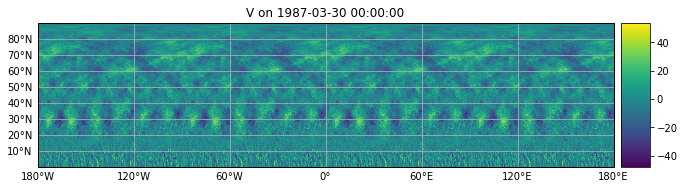

In [42]:
rcParams['figure.figsize'] = (10.0, 10.0)

# after importing cartopy
# use the following to give projection type: 
#    projection=cartopy.crs.Mollweide()
# or projection=cartopy.crs.Orthographic()

#fieldset.U.show(land=False, projection=cartopy.crs.Orthographic(central_latitude=45))
fieldset.V.show(land=False)

In [43]:
# get uniformly distributed seed points on a spherical surface 
# to avoid concentration of points near poles

# https://stackoverflow.com/questions/33976911/generate-a-random-sample-of-points-distributed-on-the-surface-of-a-unit-sphere/33977070

def sample_spherical(npoints, ndim=3):
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    return vec

def get_uni_points(npoints=100, zcut1=0, zcut2=1):

    # zcut (range 0 to 1) can be used to truncate the lower latitude
    # of the latitude range of particles.
    # zcut=0 means particles will be produced 
    # from equator to north pole
    
    radius=1

    xi, yi, zi = radius*sample_spherical(npoints)

    # choose only northern hemisphere points
    mask = ((zi > zcut1) & (zi<zcut2))
    xiN = xi[mask]; yiN = yi[mask]; ziN = zi[mask]

    if False:
        theta = np.linspace(0, np.pi, 20)
        phi = np.linspace(0, 2 * np.pi, 40)
        x = radius*np.outer(np.sin(phi), np.cos(theta))
        y = radius*np.outer(np.sin(phi), np.sin(theta))
        z = radius*np.outer(np.cos(phi), np.ones_like(theta))
        
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_wireframe(x, y, z, color='k', rstride=1, cstride=1)
        ax.scatter(xiN, yiN, ziN, s=10, c='r', zorder=10)
        plt.show()

    # get lon and lats
    uni_phis = 180*np.arctan2(yiN,xiN)/np.pi
    xyN = np.sqrt(xiN**2 + yiN**2)
    uni_thetas = 90-180*np.arctan2(xyN,ziN)/np.pi

    return uni_thetas, uni_phis

if False:

    # check output points
    
    # create the projections
    ortho = cartopy.crs.Orthographic(central_longitude=0, central_latitude=45)
    geo = cartopy.crs.Geodetic()

    # plot native orthographic scatter points
    ax = plt.axes(projection=ortho)

    ax.set_global()
    ax.gridlines()
    temp_lats, temp_lons =  get_uni_points(npoints=6000)
    print(temp_lats.shape)
    ax.plot(temp_lons, temp_lats, '.', c='r', transform=geo, alpha=1, ms=3)

    plt.show()


In [44]:
plats, plons =  get_uni_points(npoints=50000, zcut1=0, zcut2=1)

pset = ParticleSet.from_list(fieldset=fieldset,   # the fields on which the particles are advected
                             pclass=JITParticle,  # the type of particles (JITParticle or ScipyParticle)
                             lon=plons, # a vector of release longitudes 
                             lat=plats # a vector of release latitudes
                            )   
#print(pset)

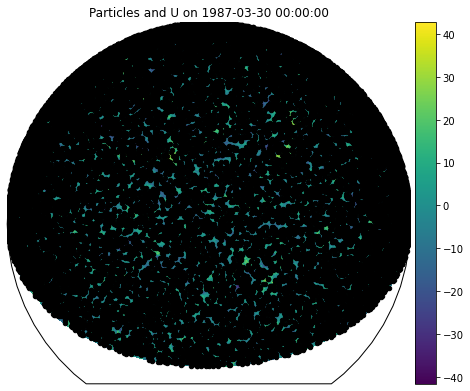

In [45]:
rcParams['figure.figsize'] = (7, 7)
pset.show(field=fieldset.U, land=False, projection=cartopy.crs.Orthographic(central_latitude=45))

In [46]:
# function to create peridiocity in zonal direction
def periodicBC(particle, fieldset, time):
    if particle.lon < fieldset.halo_west:
        particle.lon += fieldset.halo_east - fieldset.halo_west
    elif particle.lon > fieldset.halo_east:
        particle.lon -= fieldset.halo_east - fieldset.halo_west

# delete out of domain particles
def DeleteParticle(particle, fieldset, time):
    particle.delete()

output_file = pset.ParticleFile(name='NestedFieldParticle_thin_noZon.nc', 
                                outputdt=3600 # in seconds
                               )
pset.execute(AdvectionRK4+ pset.Kernel(periodicBC), 
             runtime=timedelta(hours=300),    # the total length of the run
             dt=timedelta(hours=1),      # the timestep of the kernel
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
             output_file = output_file)

output_file.export()

INFO: Compiled JITParticleAdvectionRK4periodicBC ==> /tmp/parcels-1000/ec6d078f19cea8373f2d2a6c6c9dd4d9_0.so
INFO: Temporary output files are stored in out-DKSXJVRI.
INFO: You can use "parcels_convert_npydir_to_netcdf out-DKSXJVRI" to convert these to a NetCDF file during the run.
100% (1080000.0 of 1080000.0) |##########| Elapsed Time: 0:03:02 Time:  0:03:02


In [11]:
rcParams['figure.figsize'] = (10.0, 10.0)


#plotTrajectoriesFile('NestedFieldParticle.nc', mode='movie2d_notebook')
#plotTrajectoriesFile('NestedFieldParticle.nc', mode='2d')